In [2]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import pickle
import re
from tqdm import tqdm_notebook

In [3]:
dfvz = pd.read_csv("../DataFiles/FullDataSet.csv")

logDC = dfvz[['seq','log.label']]
logDC.set_index('seq', inplace=True)
pickle.dump(logDC, open("../DataFilesProcessed/logDC.pickle", "wb"))


In [3]:
print('Data Frame Columns:\n', dfvz.columns, '\n\n', '**********\n')
print('Data Frame Shape:', dfvz.shape)

Data Frame Columns:
 Index(['seq', 'label', 'log.label', 'z1.1', 'z1.2', 'z1.3', 'z2.1', 'z2.2',
       'z2.3', 'z3.1', 'z3.2', 'z3.3', 'z4.1', 'z4.2', 'z4.3',
       'z3.linear.pred', 'z3.svm.pred', 'z3.tree.pred', 'z3.knn.pred',
       'vhse1.1', 'vhse1.2', 'vhse1.3', 'vhse1.4', 'vhse1.5', 'vhse1.6',
       'vhse1.7', 'vhse1.8', 'vhse2.1', 'vhse2.2', 'vhse2.3', 'vhse2.4',
       'vhse2.5', 'vhse2.6', 'vhse2.7', 'vhse2.8', 'vhse3.1', 'vhse3.2',
       'vhse3.3', 'vhse3.4', 'vhse3.5', 'vhse3.6', 'vhse3.7', 'vhse3.8',
       'vhse4.1', 'vhse4.2', 'vhse4.3', 'vhse4.4', 'vhse4.5', 'vhse4.6',
       'vhse4.7', 'vhse4.8', 'vhse.linear.pred', 'vhse.svm.pred',
       'vhse.tree.pred', 'vhse.knn.pred'],
      dtype='object') 

 **********

Data Frame Shape: (67278, 55)


In [4]:
#correcting  vhse.4 value for N from -0.69 to +0.69 uniformly
dfvz.loc[dfvz['vhse1.4'] == -0.69,'vhse1.4'] = 0.69
dfvz.loc[dfvz['vhse2.4'] == -0.69,'vhse2.4'] = 0.69
dfvz.loc[dfvz['vhse3.4'] == -0.69,'vhse3.4'] = 0.69
dfvz.loc[dfvz['vhse4.4'] == -0.69,'vhse4.4'] = 0.69

In [5]:
#create look up dict for vhse and z features based on base
vhse = dict ()
for featn in range(8):
    pos = 2 # independent , for any base position (1 to 4)
    base,ind = np.unique([dfvz['seq'][i][pos-1] for i in range(len(dfvz))], return_index=True) 
    val = dfvz['vhse'+ str(pos) +'.' + str(featn+1)][ind]
    vhse[featn+1] = dict(zip(base,val))
    
    
zfeat = dict ()
featn = 1
for featn in range(3):
    pos = 2 # independent , for any base position (1 to 4)
    base,ind = np.unique([dfvz['seq'][i][pos-1] for i in range(len(dfvz))], return_index=True) 
    val = dfvz['z'+ str(pos) +'.' + str(featn+1)][ind]
    zfeat[featn+1] = dict(zip(base,val))
    
    
##save this dicts

In [6]:
#Genearte pattern based features for sequence
#list of amino acid codes
aa = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
len(aa)

20

In [7]:
df = dfvz.loc[:,['seq']]

In [8]:
#Generate cross products 
import itertools
cp3 = [p for p in itertools.product(aa, repeat=3)]
cp2 = [p for p in itertools.product(aa, repeat=2)]
cp1 = [p for p in itertools.product(aa, repeat=1)]

In [9]:
#Genearate patterns
cp3pat1 = ['.'+cp3[i][0]+cp3[i][1]+cp3[i][2] for i in range(len(cp3))]
cp3pat2 = [cp3[i][0]+'.'+cp3[i][1]+cp3[i][2] for i in range(len(cp3))]
cp3pat3 = [cp3[i][0]+cp3[i][1]+'.'+cp3[i][2] for i in range(len(cp3))]
cp3pat4 = [cp3[i][0]+cp3[i][1]+cp3[i][2]+'.' for i in range(len(cp3))]

In [10]:
cp2pat1 = ['.'+'.'+cp2[i][0]+cp2[i][1] for i in range(len(cp2))]
cp2pat2 = ['.'+cp2[i][0]+'.'+cp2[i][1] for i in range(len(cp2))]
cp2pat3 = ['.'+cp2[i][0]+cp2[i][1]+'.' for i in range(len(cp2))]

cp2pat4 = [cp2[i][0]+'.'+'.'+cp2[i][1] for i in range(len(cp2))]
cp2pat5 = [cp2[i][0]+'.'+cp2[i][1]+'.' for i in range(len(cp2))]
cp2pat6 = [cp2[i][0]+cp2[i][1]+'.'+'.' for i in range(len(cp2))]

In [11]:
cp1pat1 = ['.'+'.'+'.'+cp1[i][0] for i in range(len(cp1))]
cp1pat2 = ['.'+'.'+cp1[i][0]+'.' for i in range(len(cp1))]
cp1pat3 = ['.'+cp1[i][0]+'.'+'.' for i in range(len(cp1))]
cp1pat4 = [cp1[i][0]+'.'+'.'+'.' for i in range(len(cp1))]

In [12]:
# len(cp3pat1) #8000 .AAA etc
# len(cp2pat1) #400 ..AA etc
# len(cp1pat1) #20 ...A etc

In [13]:
#look up for patterns, create feature for each pattern if present, assign value of 1 if present
cppat_key = ['cp3pat1','cp3pat2','cp3pat3','cp3pat4','cp2pat1','cp2pat2','cp2pat3','cp2pat4','cp2pat5','cp2pat6','cp1pat1','cp1pat2','cp1pat3','cp1pat4']
cppat_value = [cp3pat1,cp3pat2,cp3pat3,cp3pat4,cp2pat1,cp2pat2,cp2pat3,cp2pat4,cp2pat5,cp2pat6,cp1pat1,cp1pat2,cp1pat3,cp1pat4]
cppat = dict(zip(cppat_key, cppat_value))

In [14]:
cppat.keys()
#save this dict

dict_keys(['cp3pat1', 'cp3pat2', 'cp3pat3', 'cp3pat4', 'cp2pat1', 'cp2pat2', 'cp2pat3', 'cp2pat4', 'cp2pat5', 'cp2pat6', 'cp1pat1', 'cp1pat2', 'cp1pat3', 'cp1pat4'])

In [15]:

#faster
for k, cppats in tqdm_notebook(cppat.items(), desc='1st Loop'):
    print('Adding ' + str(k) +' features.')
    thr =100
    for c,pat in enumerate(tqdm_notebook(cppats, desc='2nd Loop', leave=False)):
        if c == thr:
            print(str(c) +'  done!')
            thr = thr +100
        rematch = [re.search(pat,s) for s in df['seq']]
        df[pat] = rematch

Adding cp3pat1 features.


100  done!
200  done!
300  done!
400  done!
500  done!
600  done!
700  done!
800  done!
900  done!
1000  done!
1100  done!
1200  done!
1300  done!
1400  done!
1500  done!
1600  done!
1700  done!
1800  done!
1900  done!
2000  done!
2100  done!
2200  done!
2300  done!
2400  done!
2500  done!
2600  done!
2700  done!
2800  done!
2900  done!
3000  done!
3100  done!
3200  done!
3300  done!
3400  done!
3500  done!
3600  done!
3700  done!
3800  done!
3900  done!
4000  done!
4100  done!
4200  done!
4300  done!
4400  done!
4500  done!
4600  done!
4700  done!
4800  done!
4900  done!
5000  done!
5100  done!
5200  done!
5300  done!
5400  done!
5500  done!
5600  done!
5700  done!
5800  done!
5900  done!
6000  done!
6100  done!
6200  done!
6300  done!
6400  done!
6500  done!
6600  done!
6700  done!
6800  done!
6900  done!
7000  done!
7100  done!
7200  done!
7300  done!
7400  done!
7500  done!
7600  done!
7700  done!
7800  done!
7900  done!
Adding cp3pat2 features.


100  done!
200  done!
300  done!
400  done!
500  done!
600  done!
700  done!
800  done!
900  done!
1000  done!
1100  done!
1200  done!
1300  done!
1400  done!
1500  done!
1600  done!
1700  done!
1800  done!
1900  done!
2000  done!
2100  done!
2200  done!
2300  done!
2400  done!
2500  done!
2600  done!
2700  done!
2800  done!
2900  done!
3000  done!
3100  done!
3200  done!
3300  done!
3400  done!
3500  done!
3600  done!
3700  done!
3800  done!
3900  done!
4000  done!
4100  done!
4200  done!
4300  done!
4400  done!
4500  done!
4600  done!
4700  done!
4800  done!
4900  done!
5000  done!
5100  done!
5200  done!
5300  done!
5400  done!
5500  done!
5600  done!
5700  done!
5800  done!
5900  done!
6000  done!
6100  done!
6200  done!
6300  done!
6400  done!
6500  done!
6600  done!
6700  done!
6800  done!
6900  done!
7000  done!
7100  done!
7200  done!
7300  done!
7400  done!
7500  done!
7600  done!
7700  done!
7800  done!
7900  done!
Adding cp3pat3 features.


100  done!
200  done!
300  done!
400  done!
500  done!
600  done!
700  done!
800  done!
900  done!
1000  done!
1100  done!
1200  done!
1300  done!
1400  done!
1500  done!
1600  done!
1700  done!
1800  done!
1900  done!
2000  done!
2100  done!
2200  done!
2300  done!
2400  done!
2500  done!
2600  done!
2700  done!
2800  done!
2900  done!
3000  done!
3100  done!
3200  done!
3300  done!
3400  done!
3500  done!
3600  done!
3700  done!
3800  done!
3900  done!
4000  done!
4100  done!
4200  done!
4300  done!
4400  done!
4500  done!
4600  done!
4700  done!
4800  done!
4900  done!
5000  done!
5100  done!
5200  done!
5300  done!
5400  done!
5500  done!
5600  done!
5700  done!
5800  done!
5900  done!
6000  done!
6100  done!
6200  done!
6300  done!
6400  done!
6500  done!
6600  done!
6700  done!
6800  done!
6900  done!
7000  done!
7100  done!
7200  done!
7300  done!
7400  done!
7500  done!
7600  done!
7700  done!
7800  done!
7900  done!
Adding cp3pat4 features.


100  done!
200  done!
300  done!
400  done!
500  done!
600  done!
700  done!
800  done!
900  done!
1000  done!
1100  done!
1200  done!
1300  done!
1400  done!
1500  done!
1600  done!
1700  done!
1800  done!
1900  done!
2000  done!
2100  done!
2200  done!
2300  done!
2400  done!
2500  done!
2600  done!
2700  done!
2800  done!
2900  done!
3000  done!
3100  done!
3200  done!
3300  done!
3400  done!
3500  done!
3600  done!
3700  done!
3800  done!
3900  done!
4000  done!
4100  done!
4200  done!
4300  done!
4400  done!
4500  done!
4600  done!
4700  done!
4800  done!
4900  done!
5000  done!
5100  done!
5200  done!
5300  done!
5400  done!
5500  done!
5600  done!
5700  done!
5800  done!
5900  done!
6000  done!
6100  done!
6200  done!
6300  done!
6400  done!
6500  done!
6600  done!
6700  done!
6800  done!
6900  done!
7000  done!
7100  done!
7200  done!
7300  done!
7400  done!
7500  done!
7600  done!
7700  done!
7800  done!
7900  done!
Adding cp2pat1 features.


100  done!
200  done!
300  done!
Adding cp2pat2 features.


100  done!
200  done!
300  done!
Adding cp2pat3 features.


100  done!
200  done!
300  done!
Adding cp2pat4 features.


100  done!
200  done!
300  done!
Adding cp2pat5 features.


100  done!
200  done!
300  done!
Adding cp2pat6 features.


100  done!
200  done!
300  done!
Adding cp1pat1 features.


Adding cp1pat2 features.


Adding cp1pat3 features.


Adding cp1pat4 features.


In [16]:
len(cppats)

20

In [17]:
#dfcopy = copy.deepcopy(df)
dfcopy = df

#dfcopy.iloc[:,:3]
dfcopy.iloc[:,1:]

,.AAA,.AAR,.AAN,.AAD,.AAC,.AAE,.AAQ,.AAG,.AAH,.AAI,...,L...,K...,M...,F...,P...,S...,T...,W...,Y...,V...
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='TVPT'>",None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='VYVY'>"
2,None,None,None,None,None,None,None,None,None,None,...,None,"<re.Match object; span=(0, 4), match='KNML'>",None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,...,None,"<re.Match object; span=(0, 4), match='KTIA'>",None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,"<re.Match object; span=(0, 4), match='LHFR'>",None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67273,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='VWVL'>"
67274,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='YDYL'>",None
67275,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='YFLA'>",None
67276,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"<re.Match object; span=(0, 4), match='YPNC'>",None


In [18]:
df_bool=pd.notnull(dfcopy.iloc[:,1:])

In [19]:
df_bool['seq'] = dfcopy['seq']
df_bool['label'] = dfvz['label']
df_bool['log.label'] = dfvz['log.label']

In [20]:
df_bool.to_pickle('df_bool.pkl')

In [21]:
#df_int = copy.deepcopy(df_bool)
df_int = df_bool

In [22]:
df_int = df_int.applymap(lambda x: 1 if x == True else x)
df_int = df_int.applymap(lambda x: 0 if x == False else x)

In [23]:
df_int.to_csv('df_int.csv')

In [24]:
#get column sums
dfs = df_int.sum(axis=0)

In [25]:
def getselcol(dfsum,thr):
    selcol = [dfsum[:-3].values>thr]# keep only features with alteast 'thr' number of sequences
    selcol = np.array(selcol)
    selcol = np.append(selcol,np.array([True,True, False])) #add sequence and label columns
    # selcol = np.insert(selcol, 0, True)
    return selcol

In [26]:
dfs_sel = [dfs[:-3].values>thr]

In [27]:
dfs_sel

[array([False, False, False, ...,  True,  True,  True])]

In [28]:
dfs_sel = np.array(dfs_sel)

In [29]:
dfs_sel

array([[False, False, False, ...,  True,  True,  True]])

In [30]:
np.append(dfs_sel, np.array([True, True, False]))

array([False, False, False, ...,  True,  True, False])

In [31]:
dfs[:-3]

.AAA      17
.AAR      16
.AAN      11
.AAD      11
.AAC       6
        ... 
S...    4839
T...    4492
W...    3060
Y...    2958
V...    4820
Length: 34480, dtype: object

In [32]:
dfs

.AAA                                                        17
.AAR                                                        16
.AAN                                                        11
.AAD                                                        11
.AAC                                                         6
                                   ...                        
Y...                                                      2958
V...                                                      4820
seq          TVPTVYVYKNMLKTIALHFRRPDFELIWQSGMVGTYHSKSFYLNSN...
label                                                  137.808
log.label                                              -186967
Length: 34483, dtype: object

Text(0, 0.5, 'number of features')

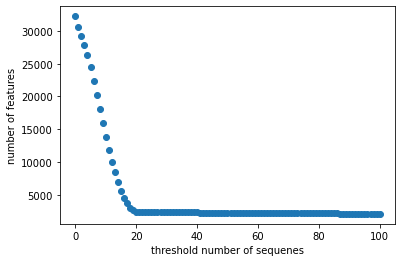

In [33]:
thrlist =  np.linspace(0,100,101).astype(int)
seln = [sum(getselcol(dfs,t)) for t in thrlist]
plt.scatter(thrlist,seln)
plt.xlabel('threshold number of sequenes')
plt.ylabel('number of features')

In [34]:
sel20 = getselcol(dfs,20)
df20 = df_int.loc[:,sel20]

In [35]:
len(sel20)

34483

In [36]:
len(df_int.columns)

34483

In [37]:
df_int.columns[-1]

'log.label'

In [38]:
df20.to_pickle('df20.pkl')

In [39]:
df20.to_csv('df20.csv')

In [40]:
#sel10 = getselcol(dfs,10)
#df10 = df_int.loc[:,sel10]

#sel15 = getselcol(dfs,15)
#df15 = df_int.loc[:,sel15]

In [41]:
#df10.to_csv('df10.csv')
#df15.to_csv('df15.csv')

In [42]:
len(df20.columns)
pat_feat20 = list(df20.columns)

In [43]:
len(df20.columns)

2398

In [44]:
pat_fulllist = [pat for cppats in cppat.values() for pat in cppats]
len([pat for cppats in cppat.values() for pat in cppats])

34480

In [45]:
#load dataset
# df20 = pd.read_csv('df20.csv')
# dfvz = pd.read_csv("FullDataSet-UpdatedSM.csv")

#Define X and y
Xp_names = df20.loc[:,'..AA':'V...'].columns
Xz_names = dfvz.loc[:,'z1.1':'z4.3'].columns
Xv_names = dfvz.loc[:,'vhse1.1':'vhse4.8'].columns
Xvz_names = list(Xz_names)+list(Xv_names) #zscale and vhse combined #(67278, 44)
Xpvz_names = list(Xvz_names)+list(Xp_names)#pattern and zscale, vhse combined #(67278, 2440)
Xpvz=pd.concat([dfvz.loc[:,Xvz_names],df20.loc[:,list(Xp_names)]],axis=1)

In [46]:
Xpvz_seq = pd.concat([df20.loc[:,'seq'],Xpvz.loc[:,list(Xpvz_names)]],axis=1)
Xpvz_seq.set_index('seq',drop=True, inplace = True)

In [47]:
#Xpvz_names # save this ordering of features in extracted dataframe
list(Xpvz.columns)
Xpvz_names == list(Xpvz.columns)

True

In [48]:
#save the dictionary to be for feature selection

feat_extdict = dict(zip(['z','vhse', 'pat_feat20','Xpvz_names'],[zfeat, vhse, pat_feat20,Xpvz_names]))
pickle.dump(feat_extdict, open("feature_extractor_dict_cor.pickle", "wb")) 

In [ ]:
####********can start here*********##


In [49]:

feat_extdict  = pickle.load(open("feature_extractor_dict_cor.pickle", "rb"))

In [50]:
feat_extdict.keys()

dict_keys(['z', 'vhse', 'pat_feat20', 'Xpvz_names'])

In [51]:
#example extraction - #make function of this

#seq_ex = dfvz['seq'][345]
seq_ex = 'MNKG'

ext_feat = dict()
ext_feat[seq_ex] = dict()
for pos,b in enumerate(seq_ex):
    for featn in range(8):
        ext_feat[seq_ex]['vhse'+str(pos+1)+'.'+str(featn+1)] = feat_extdict['vhse'][featn+1][b]
    for featn in range(3):
        ext_feat[seq_ex]['z'+str(pos+1)+'.'+str(featn+1)] = feat_extdict['z'][featn+1][b] 
        
#verify the extraction
#pd.concat([dfvz.iloc[345], pd.DataFrame(ext_feat)],axis =1,join='inner')

for pat in feat_extdict['pat_feat20']:
    ext_feat[seq_ex][pat] = int(pd.notnull(re.search(pat,seq_ex)))

In [52]:
len(ext_feat[seq_ex])
featext_df = pd.DataFrame(ext_feat).T
featext_df.loc[:,feat_extdict['Xpvz_names']]

,z1.1,z1.2,z1.3,z2.1,z2.2,z2.3,z3.1,z3.2,z3.3,z4.1,...,L...,K...,M...,F...,P...,S...,T...,W...,Y...,V...
MNKG,-2.49,-0.27,-0.41,3.22,1.45,0.84,2.84,1.41,-3.14,2.23,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
import re
def feat_extractor(seqs, ft_dict):
    #seqs: array of sequences to extract features from
    #ft_dict: feature extraction dict
    
    ext_feat = dict()
    for seq_ex in seqs:
        ext_feat[seq_ex] = dict()
        for pos,b in enumerate(seq_ex):
            for featn in range(8):
                ext_feat[seq_ex]['vhse'+str(pos+1)+'.'+str(featn+1)] = ft_dict['vhse'][featn+1][b]
            for featn in range(3):
                ext_feat[seq_ex]['z'+str(pos+1)+'.'+str(featn+1)] = ft_dict['z'][featn+1][b]

        for pat in feat_extdict['pat_feat20']:
            ext_feat[seq_ex][pat] = int(pd.notnull(re.search(pat,seq_ex)))
    
    featext_df = pd.DataFrame(ext_feat).T
    return(featext_df.loc[:,ft_dict['Xpvz_names']])

In [54]:
#usage example 1
feat_extractor(['MNKG'],feat_extdict)

,z1.1,z1.2,z1.3,z2.1,z2.2,z2.3,z3.1,z3.2,z3.3,z4.1,...,L...,K...,M...,F...,P...,S...,T...,W...,Y...,V...
MNKG,-2.49,-0.27,-0.41,3.22,1.45,0.84,2.84,1.41,-3.14,2.23,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#usage example 2
feat_extractor(['MNKG','ARAA'],feat_extdict)

,z1.1,z1.2,z1.3,z2.1,z2.2,z2.3,z3.1,z3.2,z3.3,z4.1,...,L...,K...,M...,F...,P...,S...,T...,W...,Y...,V...
MNKG,-2.49,-0.27,-0.41,3.22,1.45,0.84,2.84,1.41,-3.14,2.23,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARAA,0.07,-1.73,0.09,2.88,2.52,-3.44,0.07,-1.73,0.09,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#verify the matrix
Xpvz_seq.loc[['MNKG','ARAA'],:]

,z1.1,z1.2,z1.3,z2.1,z2.2,z2.3,z3.1,z3.2,z3.3,z4.1,...,L...,K...,M...,F...,P...,S...,T...,W...,Y...,V...
seq,,,,,,,,,,,,,,,,,,,,,
MNKG,-2.49,-0.27,-0.41,3.22,1.45,0.84,2.84,1.41,-3.14,2.23,...,0,0,1,0,0,0,0,0,0,0
ARAA,0.07,-1.73,0.09,2.88,2.52,-3.44,0.07,-1.73,0.09,0.07,...,0,0,0,0,0,0,0,0,0,0
